In [57]:
import pandas as pd # to mess with the faces database, we are going to need to manage some spreadsheets
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

%matplotlib inline

import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", path)

Path to dataset files: /home/ccurtis/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


In [58]:
# We need a tool that converts images into grayscale (i.e. all pixel values in [0, 1])
def gray_scale_convert(image):
    rescaled_image = np.zeros((image.shape[0], image.shape[1]))
    rescaled_image[:, :] = image
    rescaled_image -= np.min(rescaled_image)
    rescaled_image /= np.max(rescaled_image)
    return rescaled_image

In [63]:
# We need to be able to pass in a directory and build an image list
def file_builder(directory):
    image_list = []
    # iterate over files in
    # that directory
    cnt = 0
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if ".csv" not in filename:
                input_matrix = io.imread(os.path.join(root, filename))
                height, width, ntot = input_matrix.shape
                for jj in range(ntot):                
                    squeeze_matrix = np.squeeze(input_matrix[:, :, jj])
                    input_image = gray_scale_convert(squeeze_matrix)
                    image_list.append( input_image )
                    cnt += 1
            if cnt >= 1000:
                return image_list            
    return image_list

In [64]:
work = os.getcwd()
print(f"Working directory is: {work}")
image_path = path + "/lfw-deepfunnled"
image_list = file_builder(path)

Working directory is: /home/ccurtis/Desktop/MATH_596_Git_Clone/Assignments


In [65]:
tot_images = len(image_list)
inds = np.arange(tot_images, dtype=int)

# shuffle image_list 
rng = np.random.default_rng()
rng.shuffle(inds)

train_list = np.array(image_list)[ inds[:int(.8*tot_images)] ]
test_list = np.array(image_list)[ inds[int(.8*tot_images):] ]

# downsample by a factor of 10 to get overdetermined problem
train_mat = np.zeros((25*25,train_list.shape[0]))
test_mat = np.zeros((25*25,test_list.shape[0]))
for jj in range(train_list.shape[0]):
    train_col = train_list[jj][::10, ::10].flatten()
    train_mat[:, jj] = train_col/np.linalg.norm(train_col)
    
for jj in range(test_list.shape[0]):
    test_col = test_list[jj][::10, ::10].flatten()
    test_mat[:, jj] = test_col/np.linalg.norm(test_col)


In [75]:
alpha = cp.Variable(train_mat.shape[1])
ep = cp.Parameter(nonneg=True)

objective = cp.Minimize(cp.norm(alpha, 1))
constraint = [cp.sum_squares(train_mat@alpha-test_mat[:, 0])/(2.*train_mat.shape[0]) <= ep]
prob = cp.Problem(objective, constraint)

ep.value = 1e-5
prob.solve()

1.457100125661315

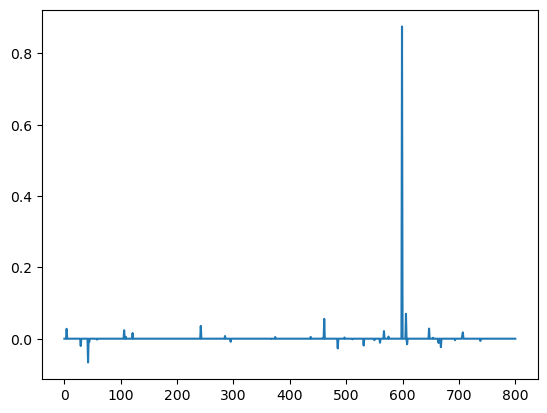

In [76]:
plt.plot(alpha.value)

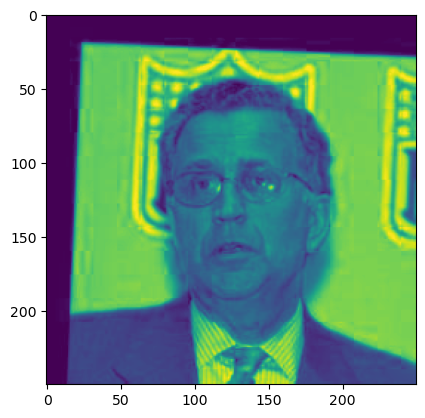

In [77]:
image_detected = np.argmax(alpha.value)
plt.imshow(test_list[0])

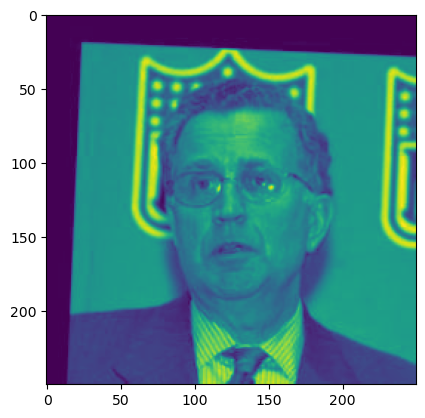

In [78]:
plt.imshow(train_list[image_detected])

## Proble